# HOMEWORK 10 - Spatial Data Analysis : Winter - Summer comparison
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

## Import initial libraries

In [51]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import os

## Working with Shape File

### Loading Census Tract Shape File¶

In [52]:
from geopandas import GeoDataFrame
shape_path=os.getenv('PUIDATA') + '/hw10/CT_Shape/ct_shape.shp'
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [53]:
from fiona.crs import from_epsg

ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

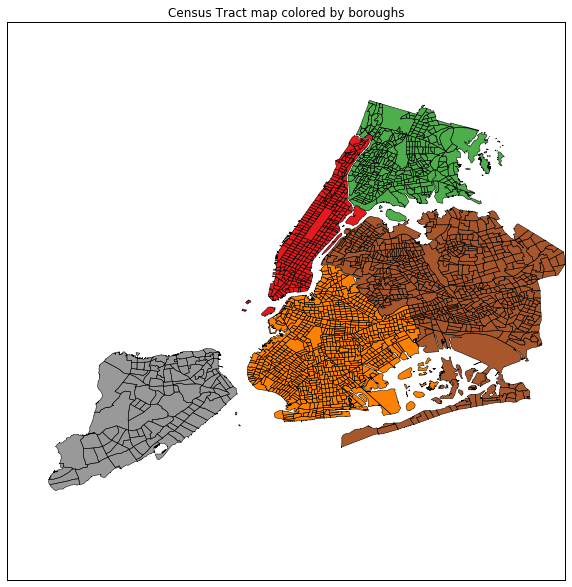

In [54]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

#### Figure 1
The map shows the NYC area with different colors for the boroughs.

### Map NYC Population density

#### Load Census Data for 2010

In [55]:
ct_data=DataFrame.from_csv(os.getenv('PUIDATA') + '/hw10/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [56]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

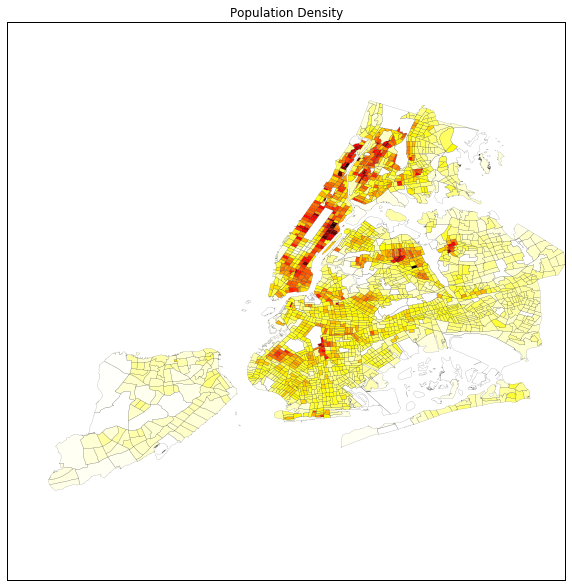

In [57]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

#### Figure 2
The map shows the population density by census track for 2010. The darker the color, the darker the track's density. Higher density areas can be seen towards Upper East Side, Bronx and Washington Heights. Also, on a second degree, Lower East Side, Upper West Side and some parts of Brooklyn and Queens.

## Explore CitiBike data

### Load CitiBike data

In [67]:
df_bike_monthly=DataFrame.from_csv(os.getenv('PUIDATA') + '/hw10/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Split summer and winter datasets

In [68]:
summerMonths = [7,8,9]
winterMonths = [12,1,2]
summerMask = df_bike_monthly.index.map(lambda x: x.month in summerMonths) 
winterMask = df_bike_monthly.index.map(lambda x: x.month in winterMonths) 
df_bike_summer_monthly = df_bike_monthly.copy()[summerMask]
df_bike_winter_monthly = df_bike_monthly.copy()[winterMask]



### Time Series Analysis for Summer

/home/pipe/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

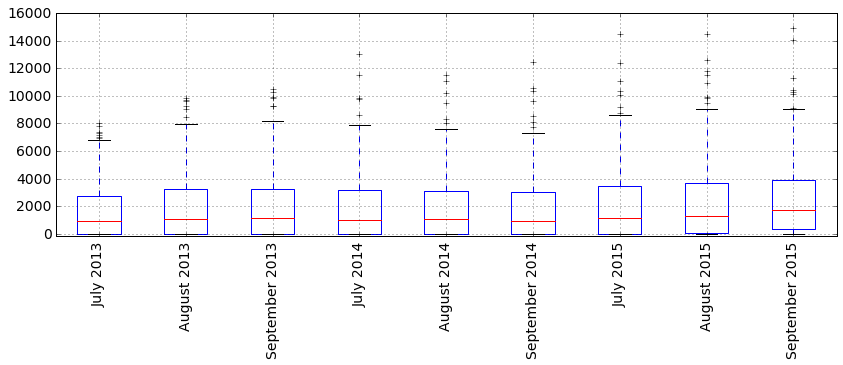

In [69]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_summer_monthly_=df_bike_summer_monthly.copy()
df_bike_summer_monthly_.index=df_bike_summer_monthly_.index.strftime("%B %Y")
df_bike_summer_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

#### Figure 3

The plot shows ridership by month during the summer months. We can se the median and interquartile range. It seems to be a stationary process, with a slight ridership's increase towards the end (summer 2015).

#### Seasonal Decomposition 


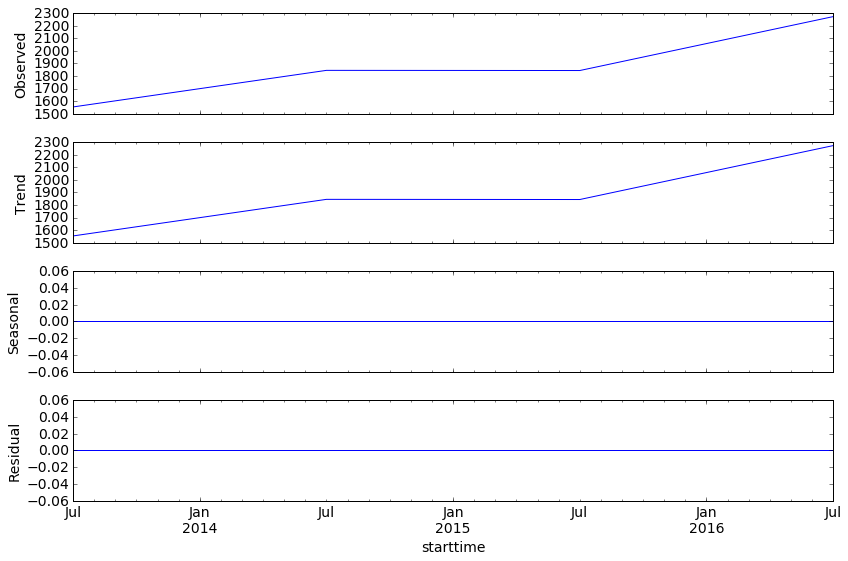

In [102]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_summer_monthly.mean(1).resample('12M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

#### Figure 4
The figure shows the seasonal decomposition for the summer months for 12 months period. We see data for July months. The tendency is there, with an increase towards the end. As we look into summmer months, there is no seasonality within them. 

## Time series for winter

/home/pipe/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  app.launch_new_instance()


(-200, 16000)

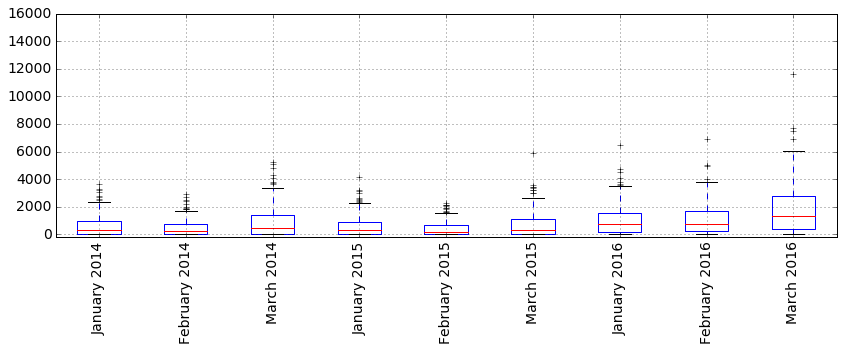

In [103]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
df_bike_winter_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

#### Figure 5
PLot shows the median and interquartile range for ridership in the winter months from 2014 to 2016. When it comes to winter, the tendency to increase towards the end is also there, although there is some drop during the 2015 winter.

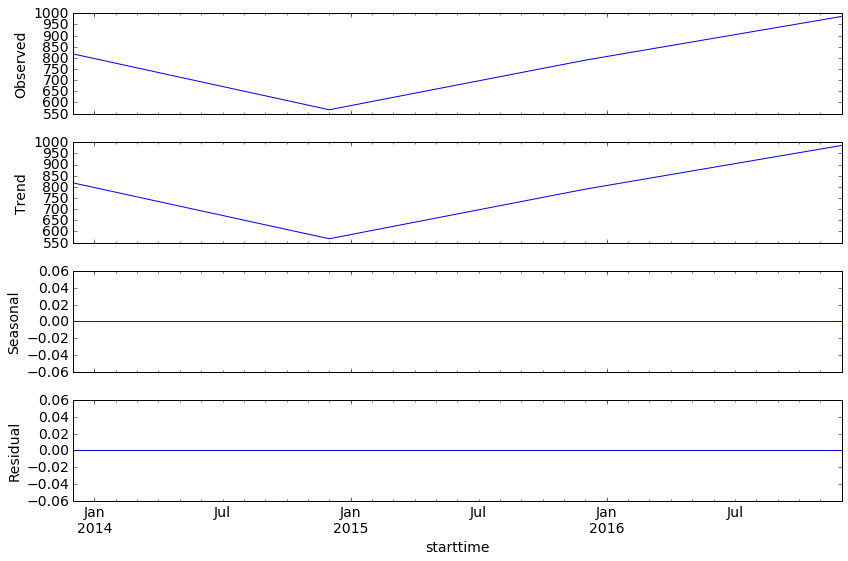

In [104]:

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_winter_monthly.mean(1).resample('12M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

#### Figure 6
The seasonal decomposition shows that estructure with a decrease in 2015 and back to the increase in 2016. This effect could be due to extraordinary temperatures (unusualy cold during 2015 and unusualy hot during 2016) and/or an increase in stations in time (also a long term tendency of biking in NYC).

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [128]:
station_id=DataFrame.from_csv(os.getenv('PUIDATA') + '/hw10/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [129]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [130]:
i = 0
ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)]

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
BoroCT2010,,,,,,,,,,,,
1009000,1009000,1,Manhattan,I,009000,90,MN19,Turtle Bay-East Midtown,3808,1.906164e+06,5527.209827,POLYGON ((-73.96661581699009 40.75324342594176...


In [131]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:3],
station_id['BoroCT2010']=a

% 100


In [132]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

#### Summer rides

In [133]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlySumAve']=summer_df_bike_monthly.sum()
station_id['MonthlyWinAve']=winter_df_bike_monthly.sum()

In [134]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlySumAve,MonthlyWinAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,22940,8939
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,35290,10657
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,89624,37257
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,33287,13394
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,62215,21320


### Add the monthly average rides to the CT shapefile 

In [137]:
# use the 
temp=station_id[['MonthlySumAve','MonthlyWinAve']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']

ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)
ct_shape_MonthlyAve.head()

/home/pipe/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,MonthlySumAve,MonthlyWinAve,station_id
BoroCT2010,,,,,,,,,,,,,,,
1000100,1000100,1,Manhattan,I,000100,1,MN99,park-cemetery-etc-Manhattan,3810,1.844421e+06,11023.047911,(POLYGON ((-74.04387761639912 40.6901876753712...,0.0,0.0,0
1000201,1000201,1,Manhattan,E,000201,2.01,MN28,Lower East Side,3809,9.716282e+05,4748.703650,POLYGON ((-73.98449647076764 40.70950966393941...,0.0,0.0,0
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,13943.0,4267.0,1197
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,13131.0,5506.0,1229
1000202,1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,17417.0,10718.0,1329


In [135]:
#f, ax = plt.subplots(figsize=(10,10))
#ct_shape_MonthlyAve.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
#plt.title("Monthly Ride Counts")

### Removing the CTs that are out of zoom boundries

In [138]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [142]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs: summer %d, winter %d" %(len(temp.MonthlySumAve),len(temp.MonthlyWinAve))

Total number of CTs: 2166
Number of zoomed CTs: summer 543, winter 543


### Map the monthly rides 

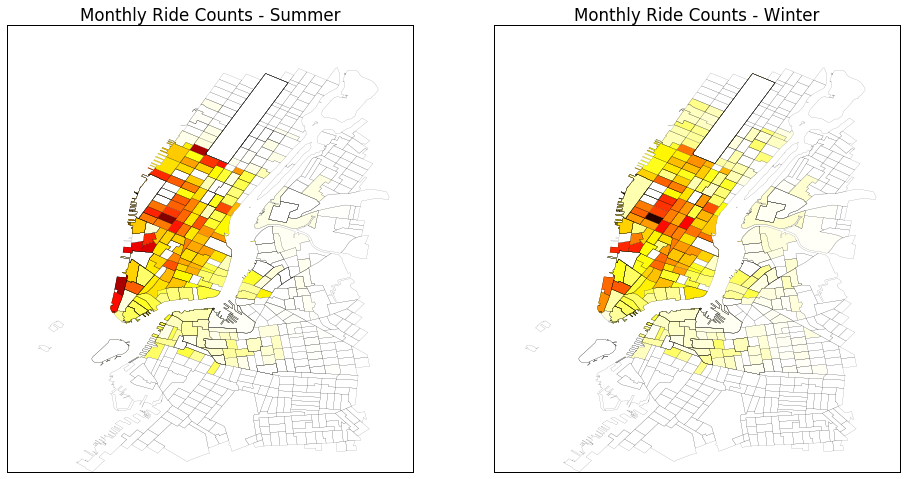

In [148]:
fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ct_shape_MonthlyAve_Zoom.plot(column='MonthlySumAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyWinAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax1.set_title('Monthly Ride Counts - Summer')
ax2.set_title('Monthly Ride Counts - Winter')

#### Figure 7
The maps shows monthly rides aggregated by census track for the summer and winter months. The pattern appears to be the same, with excepcions of a track on south close to the Hudson and those close to the Central Park. This make sense as is to be expected that during summmer people will focus more on recreational use of citibike in areas close to the Hudson river and the Central Park, with the sport related infraestrcuture that this zones have.


### Export Shapefile CTs in the CitiBike Zone

In [149]:
path=os.getenv('PUIDATA') + '/hw10/Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

In [150]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [151]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [152]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [153]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [154]:
Wmatrix, ids = qW_CT.full()

In [155]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [156]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [161]:
#Summer
MonthlyRideSum=ct_shape_MonthlyAve_Zoom.MonthlySumAve
MonthlyRideSumLag=ps.lag_spatial(qW_CT, MonthlyRideSum)

In [162]:
#Winter
MonthlyRideWin=ct_shape_MonthlyAve_Zoom.MonthlyWinAve
MonthlyRideWinLag=ps.lag_spatial(qW_CT, MonthlyRideWin)

#### Create Quantiles for maping

In [170]:
#Summer quantiles
MonthlyRideSumLagQ10 = ps.Quantiles(MonthlyRideSumLag, k=5)
MonthlyRideSumLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               161
    0.000 < x[i] <=  1803.750               158
 1803.750 < x[i] <=  8447.733               159
 8447.733 < x[i] <= 28039.143               159
28039.143 < x[i] <= 48706.786               159

In [171]:
#Winter quantiles
MonthlyRideWinLagQ10 = ps.Quantiles(MonthlyRideWinLag, k=5)
MonthlyRideWinLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=    39.286               161
   39.286 < x[i] <=  1542.231               158
 1542.231 < x[i] <=  3482.583               159
 3482.583 < x[i] <= 10658.739               159
10658.739 < x[i] <= 20961.000               159

The quantile distribution shows the expected lower ridership in winter than summer.

#### Map the monthly rides lag

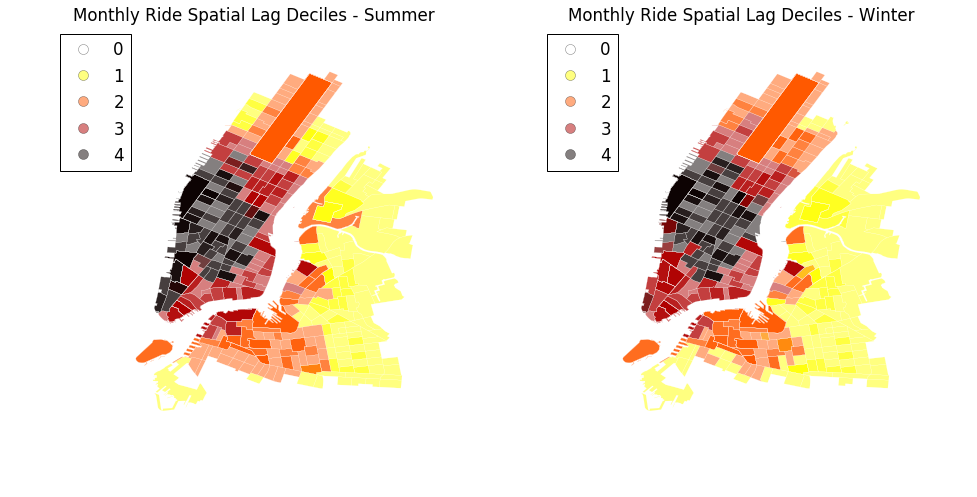

In [172]:
fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideSumLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideWinLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)

ax1.set_axis_off()
ax2.set_axis_off()

ax1.set_title("Monthly Ride Spatial Lag Deciles - Summer")
ax2.set_title("Monthly Ride Spatial Lag Deciles - Winter")


#### Figure 8
The maps show the distribution of ridership by census tracks using quantiles to group ridership. Some difference appears between summer and winter, as the summer months show the area along the Hudson in the higher quantiles, while the winter months this area is between the lower quantiles and at the same time the area around the Central Park crosses from the lowes quantiles to the middle ones.

## Global  Spatial Autocorrelation

In [174]:
#Summer
bS,aS = np.polyfit(MonthlyRideSum, MonthlyRideSumLag, 1)
bS,aS 

(0.62926871704725518, 4329.2935721604908)

In [175]:
#Winter
bW,aW = np.polyfit(MonthlyRideWin, MonthlyRideWinLag, 1)
bW,aW 

(0.65936945695485061, 1636.8483945460093)

### Moran Scatterplot

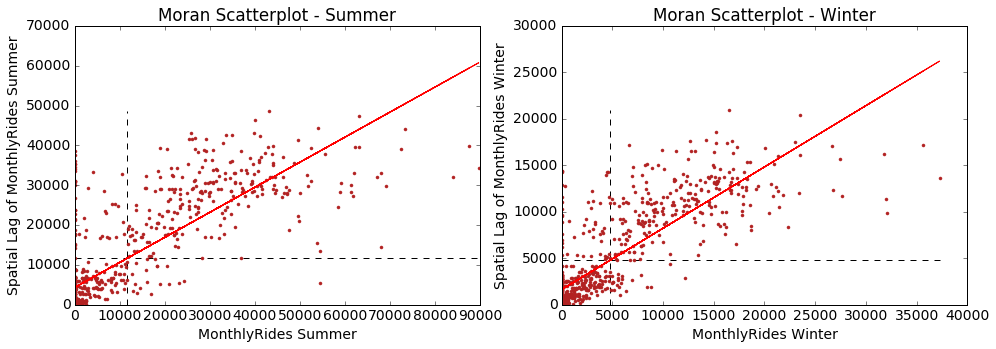

In [181]:
#Summer
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(MonthlyRideSum, MonthlyRideSumLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
ax1.vlines(MonthlyRideSum.mean(), MonthlyRideSumLag.min(), MonthlyRideSumLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax1.hlines(MonthlyRideSumLag.mean(), MonthlyRideSum.min(), MonthlyRideSum.max(), linestyle='--')

# red line of best fit using global I as slope
ax1.plot(MonthlyRideSum, aS + bS*MonthlyRideSum, 'r')

ax1.set_title('Moran Scatterplot - Summer')
ax1.set_ylabel('Spatial Lag of MonthlyRides Summer')
ax1.set_xlabel('MonthlyRides Summer')


#Winter
ax2.plot(MonthlyRideWin, MonthlyRideWinLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
ax2.vlines(MonthlyRideWin.mean(), MonthlyRideWinLag.min(), MonthlyRideWinLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax2.hlines(MonthlyRideWinLag.mean(), MonthlyRideWin.min(), MonthlyRideWin.max(), linestyle='--')

# red line of best fit using global I as slope
ax2.plot(MonthlyRideWin, aW + bW*MonthlyRideWin, 'r')
ax2.set_title('Moran Scatterplot - Winter')
ax2.set_ylabel('Spatial Lag of MonthlyRides Winter')
ax2.set_xlabel('MonthlyRides Winter')



#### Figure 9
The plot shows the spatial lag of ridership by monthly rides for the summer and winter months. The relationship appears to be the same, except for the overall lower ridership during the winter months.

### Moran's I

In [186]:
#Summer
I_MonthlyRideSum = ps.Moran(MonthlyRideSum, qW_CT)
I_MonthlyRideSum.I, I_MonthlyRideSum.p_sim

(0.62946359212848402, 0.001)

In [187]:
#Winter
I_MonthlyRideWin = ps.Moran(MonthlyRideWin, qW_CT)
I_MonthlyRideWin.I, I_MonthlyRideWin.p_sim

(0.6595138301749095, 0.001)

Although the Moran's I for winter is  slightly higher, both winter and summer have a very small $p$ value. 

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

## Local  Spatial Autocorrelation

In [188]:
print len(MonthlyRideSum)
print qW_CT

796


In [190]:
#Summer
LMo_MonthlyRideSum = ps.Moran_Local(MonthlyRideSum, qW_CT,permutations=999)
LMo_MonthlyRideSum.Is[0:5], LMo_MonthlyRideSum.p_sim[0:5]

(array([-0.        , -0.23326927,  0.01313014,  0.00869015,  0.0278383 ]),
 array([ 0.001,  0.16 ,  0.346,  0.332,  0.36 ]))

In [191]:
#Winter
LMo_MonthlyRideWin = ps.Moran_Local(MonthlyRideWin, qW_CT,permutations=999)
LMo_MonthlyRideWin.Is[0:5], LMo_MonthlyRideWin.p_sim[0:5]

(array([-0.        , -0.32301466, -0.00151236,  0.00049853, -0.05866435]),
 array([ 0.001,  0.13 ,  0.441,  0.464,  0.456]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [193]:
#Summer
sigsS = MonthlyRideSum[LMo_MonthlyRideSum.p_sim <= .001]
W_sigsS = MonthlyRideSumLag[LMo_MonthlyRideSum.p_sim <= .001]
insigsS = MonthlyRideSum[LMo_MonthlyRideSum.p_sim > .001]
W_insigsS = MonthlyRideSumLag[LMo_MonthlyRideSum.p_sim > .001]

#Winter
sigsW = MonthlyRideWin[LMo_MonthlyRideWin.p_sim <= .001]
W_sigsW = MonthlyRideWinLag[LMo_MonthlyRideWin.p_sim <= .001]
insigsW = MonthlyRideWin[LMo_MonthlyRideWin.p_sim > .001]
W_insigsW = MonthlyRideWinLag[LMo_MonthlyRideWin.p_sim > .001]

### Plot Signficant LISA

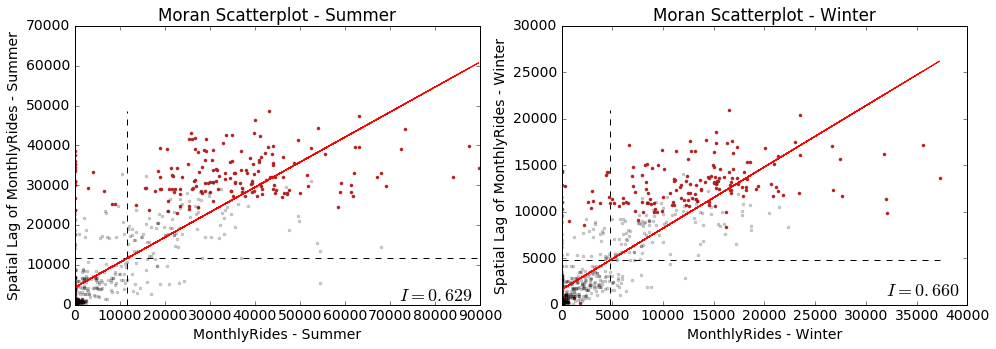

In [225]:
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(sigsS, W_sigsS, '.', color='firebrick')
ax1.plot(insigsS, W_insigsS, '.k', alpha=.2)
ax1.text(s='$I = %.3f$' % I_MonthlyRideSum.I, x=72000, y=1000, fontsize=18)

 # dashed vert at mean of the last year's PCI
ax1.vlines(MonthlyRideSum.mean(), MonthlyRideSumLag.min(), MonthlyRideSumLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
ax1.hlines(MonthlyRideSumLag.mean(), MonthlyRideSum.min(), MonthlyRideSum.max(), linestyle='--')

# red line of best fit using global I as slope
ax1.plot(MonthlyRideSum, aS + bS*MonthlyRideSum, 'r')

ax1.set_title('Moran Scatterplot - Summer')
ax1.set_ylabel('Spatial Lag of MonthlyRides - Summer')
ax1.set_xlabel('MonthlyRides - Summer')

#Winter

ax2.plot(sigsW, W_sigsW, '.', color='firebrick')
ax2.plot(insigsW, W_insigsW, '.k', alpha=.2)
ax2.text(s='$I = %.3f$' % I_MonthlyRideWin.I, x=32000, y=1000, fontsize=18)

ax2.vlines(MonthlyRideWin.mean(), MonthlyRideWinLag.min(), MonthlyRideWinLag.max(), linestyle='--')
ax2.hlines(MonthlyRideWinLag.mean(), MonthlyRideWin.min(), MonthlyRideWin.max(), linestyle='--')
ax2.plot(MonthlyRideWin, aW + bW*MonthlyRideWin, 'r')


ax2.set_title('Moran Scatterplot - Winter')
ax2.set_ylabel('Spatial Lag of MonthlyRides - Winter')
ax2.set_xlabel('MonthlyRides - Winter')


#### Figure 10
The plot shows the spatial lag of ridership by monthly rides for the summer and winter months. The relationship appears to be the same, except for the overall lower ridership during the winter months.

### Hot and Cold spots 

In [227]:
#Summer
sigS = LMo_MonthlyRideSum.p_sim < 0.01
hotspotsS = LMo_MonthlyRideSum.q==1 * sigS
coldspotsS = LMo_MonthlyRideSum.q==3 * sigS
print "Number of Summer Hotspots:", hotspotsS.sum()
print "Number of Summer Coldspots:", coldspotsS.sum()

#Winter
sigW = LMo_MonthlyRideWin.p_sim < 0.01
hotspotsW = LMo_MonthlyRideWin.q==1 * sigW
coldspotsW = LMo_MonthlyRideWin.q==3 * sigW
print "Number of Winter Hotspots:", hotspotsW.sum()
print "Number of Winter Coldspots:", coldspotsW.sum()

Number of Summer Hotspots: 188
Number of Summer Coldspots: 217
Number of Winter Hotspots: 197
Number of Winter Coldspots: 207


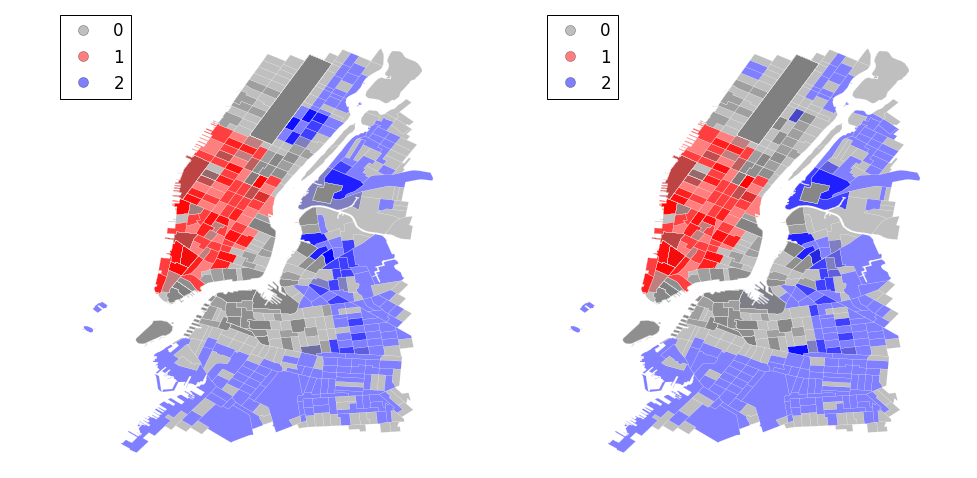

In [229]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])



hotcoldS = hotspotsS*1 + coldspotsS*2
hotcoldW = hotspotsS*1 + coldspotsW*2

fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ct_shape_MonthlyAve_Zoom.assign(cl=hotcoldS).plot(column='cl', categorical=True, 
        #k=10,
                                                 cmap=hcmap, linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ct_shape_MonthlyAve_Zoom.assign(cl=hotcoldW).plot(column='cl', categorical=True, 
        #k=10,
                                                 cmap=hcmap, linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax1.set_axis_off()
ax2.set_axis_off()


#### Figure 11
The maps show the hot and cold spots for the winter and summer months, based on ridership by census track. The pattern appears to be the same, with the exception of the Upper East Side that during winter become cold spots.